In [1]:
import mxnet as mx
import numpy as np
import os
import logging
import matplotlib.pyplot as plt
import mnist

/home/anm/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
train_x, train_y, test_x, test_y = mnist.readmnist('data/mnist')

In [3]:
height = 28
width = 28
num_channel = 1
num_train_images = np.shape(train_x)[0]
num_test_images = np.shape(test_x)[0]

In [4]:
train_x_img = train_x.reshape(num_train_images, num_channel, height, width)
test_x_img = test_x.reshape(num_test_images, num_channel, height, width)

2


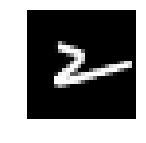

In [5]:
i = 10000
plt.figure(figsize=(2,2))
print(np.argmax(train_y[i]))
plt.imshow((train_x_img[i,0,:,:]), cmap = "Greys_r")
plt.axis('off')
plt.show()

In [6]:
epochs = 10
batch_size = 100

In [7]:
train_iter = mx.io.NDArrayIter(data = train_x_img, label = train_y, batch_size = batch_size, shuffle = True)
test_iter = mx.io.NDArrayIter(data = test_x_img, label = test_y, batch_size = batch_size)

In [8]:
data = mx.sym.Variable("data")

In [9]:
# Convolution layers
conv1 = mx.sym.Convolution(data = data, kernel = (3,3), num_filter = 32)
tanh1 = mx.sym.Activation(data = conv1, act_type = "tanh")
pool1 = mx.sym.Pooling(data = tanh1, pool_type = "max", kernel = (2,2), stride = (2,2))

conv2 = mx.sym.Convolution(data = tanh1, kernel = (5,5), num_filter = 64)
tanh2 = mx.sym.Activation(data = conv2, act_type = "tanh")
pool2 = mx.sym.Pooling(data = tanh2, pool_type = "max", kernel = (2,2), stride = (2,2))

f1 = mx.sym.flatten(data = pool2)
fc1 = mx.sym.FullyConnected(data = f1, num_hidden = 128)
tanh3 = mx.sym.Activation(data = fc1, act_type = "tanh")

fc2 = mx.sym.FullyConnected(data = tanh3, num_hidden = 10)
out = mx.sym.SoftmaxOutput(data = fc2, name = "softmax")


In [10]:
'''
f1 = mx.sym.flatten(data = data)
fc1 = mx.sym.FullyConnected(data = f1, num_hidden = 5)
tanh3 = mx.sym.Activation(data = fc1, act_type = "tanh")

fc2 = mx.sym.FullyConnected(data = tanh3, num_hidden = 10)
out = mx.sym.SoftmaxOutput(data = fc2, name = "softmax")
'''

'\nf1 = mx.sym.flatten(data = data)\nfc1 = mx.sym.FullyConnected(data = f1, num_hidden = 5)\ntanh3 = mx.sym.Activation(data = fc1, act_type = "tanh")\n\nfc2 = mx.sym.FullyConnected(data = tanh3, num_hidden = 10)\nout = mx.sym.SoftmaxOutput(data = fc2, name = "softmax")\n'

In [11]:
'''
data = mx.symbol.Variable('data')
# first conv layer
conv1 = mx.sym.Convolution(data=data, kernel=(5,5), num_filter=20)
tanh1 = mx.sym.Activation(data=conv1, act_type="tanh")
pool1 = mx.sym.Pooling(data=tanh1, pool_type="max", kernel=(2,2), stride=(2,2))
# second conv layer
conv2 = mx.sym.Convolution(data=pool1, kernel=(5,5), num_filter=50)
tanh2 = mx.sym.Activation(data=conv2, act_type="tanh")
pool2 = mx.sym.Pooling(data=tanh2, pool_type="max", kernel=(2,2), stride=(2,2))
# first fullc layer
flatten = mx.sym.Flatten(data=pool2)
fc1 = mx.symbol.FullyConnected(data=flatten, num_hidden=500)
tanh3 = mx.sym.Activation(data=fc1, act_type="tanh")
# second fullc
fc2 = mx.sym.FullyConnected(data=tanh3, num_hidden=10)
# softmax loss
out = mx.sym.SoftmaxOutput(data=fc2, name='softmax')
#mx.viz.plot_network(symbol=lenet, shape=shape)

# We visualize the network structure with output size (the batch_size is ignored.)
shape = {"data" : (batch_size, 1, 28, 28)}
mx.viz.plot_network(symbol=mlp, shape=shape)
'''

'\ndata = mx.symbol.Variable(\'data\')\n# first conv layer\nconv1 = mx.sym.Convolution(data=data, kernel=(5,5), num_filter=20)\ntanh1 = mx.sym.Activation(data=conv1, act_type="tanh")\npool1 = mx.sym.Pooling(data=tanh1, pool_type="max", kernel=(2,2), stride=(2,2))\n# second conv layer\nconv2 = mx.sym.Convolution(data=pool1, kernel=(5,5), num_filter=50)\ntanh2 = mx.sym.Activation(data=conv2, act_type="tanh")\npool2 = mx.sym.Pooling(data=tanh2, pool_type="max", kernel=(2,2), stride=(2,2))\n# first fullc layer\nflatten = mx.sym.Flatten(data=pool2)\nfc1 = mx.symbol.FullyConnected(data=flatten, num_hidden=500)\ntanh3 = mx.sym.Activation(data=fc1, act_type="tanh")\n# second fullc\nfc2 = mx.sym.FullyConnected(data=tanh3, num_hidden=10)\n# softmax loss\nout = mx.sym.SoftmaxOutput(data=fc2, name=\'softmax\')\n#mx.viz.plot_network(symbol=lenet, shape=shape)\n\n# We visualize the network structure with output size (the batch_size is ignored.)\nshape = {"data" : (batch_size, 1, 28, 28)}\nmx.viz.plo

In [12]:
train_iter.reset()
test_iter.reset()
#logging.getLogger().setLevel(logging.DEBUG)
mod = mx.mod.Module(symbol = out, context = mx.gpu(0))
mod.bind(data_shapes = train_iter.provide_data, label_shapes = train_iter.provide_label)
mod.init_params(initializer = mx.init.Xavier(magnitude = 1.))
mod.fit(train_iter,eval_data = test_iter,num_epoch = 5, optimizer_params = {'learning_rate':0.1,'momentum':.9})
mod.score(train_iter,['acc'])

total_correct = 0
batch_correct = 0
for preds,i, batch in mod.iter_predict(train_iter):
    label = batch.label[0].asnumpy().argmax(axis = 1)
    pred_label = preds[0].asnumpy().argmax(axis = 1)
    batch_correct = np.sum(label == pred_label)
    total_correct += batch_correct

print("Train Set accuracy {%2.2f}" %(total_correct/len(train_y)))

total_correct = 0
batch_correct = 0
for preds,i, batch in mod.iter_predict(test_iter):
    label = batch.label[0].asnumpy().argmax(axis = 1)
    pred_label = preds[0].asnumpy().argmax(axis = 1)
    batch_correct = np.sum(label == pred_label)
    total_correct += batch_correct

print("Test Set accuracy {%2.2f}" %(total_correct/len(test_y)))

RuntimeError: simple_bind error. Arguments:
data: (100, 1, 28, 28)
softmax_label: (100, 10)
[12:11:05] src/storage/./pooled_storage_manager.h:108: cudaMalloc failed: out of memory

Stack trace returned 10 entries:
[bt] (0) /home/anm/anaconda3/lib/python3.6/site-packages/mxnet/libmxnet.so(+0x312412) [0x7fa983434412]
[bt] (1) /home/anm/anaconda3/lib/python3.6/site-packages/mxnet/libmxnet.so(+0x3129e8) [0x7fa9834349e8]
[bt] (2) /home/anm/anaconda3/lib/python3.6/site-packages/mxnet/libmxnet.so(+0x2f641cf) [0x7fa9860861cf]
[bt] (3) /home/anm/anaconda3/lib/python3.6/site-packages/mxnet/libmxnet.so(+0x2f687dc) [0x7fa98608a7dc]
[bt] (4) /home/anm/anaconda3/lib/python3.6/site-packages/mxnet/libmxnet.so(+0x297be51) [0x7fa985a9de51]
[bt] (5) /home/anm/anaconda3/lib/python3.6/site-packages/mxnet/libmxnet.so(+0x297bfa4) [0x7fa985a9dfa4]
[bt] (6) /home/anm/anaconda3/lib/python3.6/site-packages/mxnet/libmxnet.so(+0x29882fc) [0x7fa985aaa2fc]
[bt] (7) /home/anm/anaconda3/lib/python3.6/site-packages/mxnet/libmxnet.so(+0x298ec08) [0x7fa985ab0c08]
[bt] (8) /home/anm/anaconda3/lib/python3.6/site-packages/mxnet/libmxnet.so(+0x299acac) [0x7fa985abccac]
[bt] (9) /home/anm/anaconda3/lib/python3.6/site-packages/mxnet/libmxnet.so(+0x299b3a4) [0x7fa985abd3a4]



In [ ]:
pred_label

In [ ]:
label